In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
from dataset import Train_dataset, Test_dataset
import albumentations as albu
import segmentation_models_pytorch as smp
import random 
import numpy as np
import pytorch_ssim
import pytorch_iou
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

c:\Users\neden\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
height = 512

In [4]:
BACKBONE = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, ENCODER_WEIGHTS)

In [5]:
model = smp.Unet(encoder_name = 'resnet34',encoder_weights = ENCODER_WEIGHTS, classes=1, activation='sigmoid')

In [6]:
def get_train_augmentation(height):
    train_augmentation = albu.Compose([
        albu.Resize(height,height),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=0.5),
        albu.Transpose(p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        albu.GridDistortion(p=0.5),
        albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        albu.RandomBrightnessContrast(p=0.5),
        albu.RandomGamma(p=0.5),
        albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
        albu.GaussNoise(),
        albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
    ])
    return train_augmentation

In [7]:
def get_val_augmentation(height):
    val_augmentation = albu.Compose([
        albu.Resize(height,height),
    ])
    return val_augmentation

In [8]:
train_aug = get_train_augmentation(height)
val_aug = get_val_augmentation(height)

In [9]:
train = Train_dataset(height,train_aug,'crosval/train','castom-masks/masks_machine',device,preprocess_input)
val = Train_dataset(height,val_aug,'crosval/val','castom-masks/masks_machine',device,preprocess_input)

['AAE_0014.png', 'AAE_0016.png', 'AAE_0017.png', 'AAE_0019.png', 'AAE_0021.png', 'AAE_0022.png', 'AAE_0025.png', 'AAE_0027.png', 'AAE_0028.png', 'AAE_0036.png', 'AAE_0037.png', 'AAE_0040.png', 'AAE_0041.png', 'AAE_0045.png', 'AAE_0047.png', 'AAE_0048.png', 'AAE_0057.png', 'AAE_0058.png', 'AAE_0062.png', 'AAE_0063.png', 'AAE_0068.png', 'AAE_0070.png', 'AAE_0071.png', 'AAE_0073.png', 'AAE_0076.png', 'AAE_0080.png', 'AAE_0083.png', 'AAE_0085.png', 'AAE_0087.png', 'AAE_0089.png', 'AAE_0097.png', 'AAE_0098.png', 'AAE_0100.png', 'AAE_0101.png', 'AAE_0107.png', 'AAE_0114.png', 'AAE_0116.png', 'AAE_0117.png', 'AAE_0119.png', 'AAE_0124.png', 'AAE_0125.png', 'AAE_0127.png', 'AAE_0136.png', 'AAE_0140.png', 'AAE_0144.png', 'AAE_0145.png', 'AAE_0146.png', 'AAE_0147.png', 'AAE_0150.png', 'AAE_0154.png', 'AAE_0156.png', 'AAE_0158.png', 'AAE_0161.png', 'AAE_0165.png', 'AAE_0167.png', 'AAE_0170.png', 'AAE_0173.png', 'AAE_0174.png', 'AAE_0176.png', 'AAE_0177.png', 'AAE_0179.png', 'AAE_0180.png', 'AAE_01

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

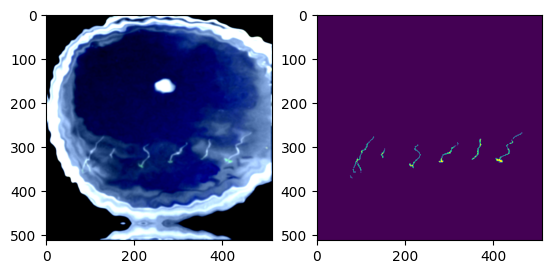

In [10]:
plt.figure()
f, axarr = plt.subplots(1,2) 
image,mask = train.__getitem__(0)
axarr[0].imshow(image.permute(1,2,0).cpu())
axarr[1].imshow(mask.permute(1,2,0).cpu())

In [11]:
train_loader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=False)

In [12]:
epochs = 200
patience = 20
model_path = 'models/best-model6.pt'

In [13]:
bce_loss = torch.nn.BCELoss(size_average=True)
ssim_loss = pytorch_ssim.SSIM(window_size=11,size_average=True)
iou_loss = pytorch_iou.IOU(size_average=True)

c:\Users\neden\miniconda3\envs\torch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [14]:
def bce_ssim_loss(pred,target):

	bce_out = bce_loss(pred,target)
	ssim_out = 1 - ssim_loss(pred,target)
	iou_out = iou_loss(pred,target)

	loss = bce_out + ssim_out + iou_out

	return loss

In [15]:
optimizer = torch.optim.Adam([ dict(params=model.parameters(), lr=0.0001)])
dice_loss = smp.losses.DiceLoss('binary')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=10,verbose=True)

In [16]:
def metric(outputs, targets):
    return 1 - dice_loss(outputs, targets)

In [17]:
model.to(device)
best_loss = 100
counter = 0
for epoch in range(epochs):
    train_loss = 0.0
    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = bce_ssim_loss(outputs, targets.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    val_loss = 0.0

    # Инициализируем списки для сбора предсказаний и истинных значений
    all_val_predictions = []
    all_val_targets = []

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader):
            outputs = model(inputs.to(device))
            loss = bce_ssim_loss(outputs, targets.to(device))
            val_loss += loss.item()
            
            # Собираем предсказания и истинные значения
            all_val_predictions.append(outputs.detach())
            all_val_targets.append(targets.detach())

    val_loss /= len(val_loader)

    scheduler.step(val_loss)

    improve = False

    if val_loss < best_loss: 
        best_loss = val_loss
        improve = True
        print('model saved')
        torch.save(model.state_dict(), model_path) 

    all_val_predictions = torch.cat(all_val_predictions, dim=0)
    all_val_targets = torch.cat(all_val_targets, dim=0)

    val_metric = metric(all_val_predictions, all_val_targets).item()

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Metric: {val_metric:.4f}")

    if not improve:
        counter += 1
        if counter > patience:
            print('Early stopping')
            break
    else:
        counter = 0
        

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


model saved
Epoch [1/200] | Train Loss: 3.0780 | Val Loss: 2.8283 | Val Metric: 0.0198


100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


model saved
Epoch [2/200] | Train Loss: 2.8331 | Val Loss: 2.7669 | Val Metric: 0.0196


100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


model saved
Epoch [3/200] | Train Loss: 2.7583 | Val Loss: 2.7063 | Val Metric: 0.0196


100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


model saved
Epoch [4/200] | Train Loss: 2.7282 | Val Loss: 2.6452 | Val Metric: 0.0197


100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


model saved
Epoch [5/200] | Train Loss: 2.6882 | Val Loss: 2.5962 | Val Metric: 0.0198


100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


model saved
Epoch [6/200] | Train Loss: 2.6558 | Val Loss: 2.5563 | Val Metric: 0.0199


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


model saved
Epoch [7/200] | Train Loss: 2.6229 | Val Loss: 2.5392 | Val Metric: 0.0199


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [8/200] | Train Loss: 2.6074 | Val Loss: 2.6268 | Val Metric: 0.0199


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [9/200] | Train Loss: 2.5844 | Val Loss: 2.6166 | Val Metric: 0.0200


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [10/200] | Train Loss: 2.5519 | Val Loss: 2.4879 | Val Metric: 0.0201


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [11/200] | Train Loss: 2.5119 | Val Loss: 2.4981 | Val Metric: 0.0201


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [12/200] | Train Loss: 2.4988 | Val Loss: 2.4536 | Val Metric: 0.0202


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


model saved
Epoch [13/200] | Train Loss: 2.4694 | Val Loss: 2.4434 | Val Metric: 0.0203


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [14/200] | Train Loss: 2.4552 | Val Loss: 2.5319 | Val Metric: 0.0203


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Epoch [15/200] | Train Loss: 2.4436 | Val Loss: 2.5686 | Val Metric: 0.0203


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


model saved
Epoch [16/200] | Train Loss: 2.4335 | Val Loss: 2.4083 | Val Metric: 0.0204


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [17/200] | Train Loss: 2.4094 | Val Loss: 2.3789 | Val Metric: 0.0204


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [18/200] | Train Loss: 2.4009 | Val Loss: 2.3680 | Val Metric: 0.0204


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Epoch [19/200] | Train Loss: 2.3986 | Val Loss: 2.8310 | Val Metric: 0.0204


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [20/200] | Train Loss: 2.4537 | Val Loss: 2.6143 | Val Metric: 0.0204


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


model saved
Epoch [21/200] | Train Loss: 2.4302 | Val Loss: 2.3626 | Val Metric: 0.0205


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


model saved
Epoch [22/200] | Train Loss: 2.3973 | Val Loss: 2.3519 | Val Metric: 0.0206


100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


model saved
Epoch [23/200] | Train Loss: 2.3689 | Val Loss: 2.3407 | Val Metric: 0.0206


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


model saved
Epoch [24/200] | Train Loss: 2.3503 | Val Loss: 2.3306 | Val Metric: 0.0207


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


model saved
Epoch [25/200] | Train Loss: 2.3432 | Val Loss: 2.3195 | Val Metric: 0.0207


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [26/200] | Train Loss: 2.3414 | Val Loss: 2.3112 | Val Metric: 0.0208


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


model saved
Epoch [27/200] | Train Loss: 2.3247 | Val Loss: 2.3077 | Val Metric: 0.0208


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


model saved
Epoch [28/200] | Train Loss: 2.3192 | Val Loss: 2.3030 | Val Metric: 0.0209


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


model saved
Epoch [29/200] | Train Loss: 2.3140 | Val Loss: 2.3004 | Val Metric: 0.0209


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


model saved
Epoch [30/200] | Train Loss: 2.3064 | Val Loss: 2.2838 | Val Metric: 0.0210


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


model saved
Epoch [31/200] | Train Loss: 2.2990 | Val Loss: 2.2796 | Val Metric: 0.0211


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


model saved
Epoch [32/200] | Train Loss: 2.2923 | Val Loss: 2.2752 | Val Metric: 0.0212


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [33/200] | Train Loss: 2.2846 | Val Loss: 2.2738 | Val Metric: 0.0213


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


model saved
Epoch [34/200] | Train Loss: 2.2781 | Val Loss: 2.2648 | Val Metric: 0.0214


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


model saved
Epoch [35/200] | Train Loss: 2.2736 | Val Loss: 2.2607 | Val Metric: 0.0216


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [36/200] | Train Loss: 2.2683 | Val Loss: 2.2532 | Val Metric: 0.0216


100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


Epoch [37/200] | Train Loss: 2.2626 | Val Loss: 2.2868 | Val Metric: 0.0215


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [38/200] | Train Loss: 2.2608 | Val Loss: 2.2619 | Val Metric: 0.0221


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


model saved
Epoch [39/200] | Train Loss: 2.2520 | Val Loss: 2.2382 | Val Metric: 0.0220


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


model saved
Epoch [40/200] | Train Loss: 2.2426 | Val Loss: 2.2288 | Val Metric: 0.0224


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [41/200] | Train Loss: 2.2393 | Val Loss: 2.2369 | Val Metric: 0.0225


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [42/200] | Train Loss: 2.2333 | Val Loss: 2.2370 | Val Metric: 0.0227


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [43/200] | Train Loss: 2.2270 | Val Loss: 2.2114 | Val Metric: 0.0226


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


model saved
Epoch [44/200] | Train Loss: 2.2208 | Val Loss: 2.2022 | Val Metric: 0.0230


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [45/200] | Train Loss: 2.2163 | Val Loss: 2.1999 | Val Metric: 0.0233


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [46/200] | Train Loss: 2.2121 | Val Loss: 2.2021 | Val Metric: 0.0234


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Epoch [47/200] | Train Loss: 2.2072 | Val Loss: 2.2052 | Val Metric: 0.0233


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [48/200] | Train Loss: 2.2006 | Val Loss: 2.1886 | Val Metric: 0.0238


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [49/200] | Train Loss: 2.1976 | Val Loss: 2.1780 | Val Metric: 0.0237


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [50/200] | Train Loss: 2.1929 | Val Loss: 2.1638 | Val Metric: 0.0237


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


model saved
Epoch [51/200] | Train Loss: 2.1893 | Val Loss: 2.1573 | Val Metric: 0.0235


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [52/200] | Train Loss: 2.1851 | Val Loss: 2.1480 | Val Metric: 0.0238


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [53/200] | Train Loss: 2.1797 | Val Loss: 2.1468 | Val Metric: 0.0242


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [54/200] | Train Loss: 2.1764 | Val Loss: 2.1460 | Val Metric: 0.0240


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [55/200] | Train Loss: 2.1707 | Val Loss: 2.1381 | Val Metric: 0.0237


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [56/200] | Train Loss: 2.1650 | Val Loss: 2.1303 | Val Metric: 0.0239


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


model saved
Epoch [57/200] | Train Loss: 2.1596 | Val Loss: 2.1198 | Val Metric: 0.0243


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [58/200] | Train Loss: 2.1623 | Val Loss: 2.1200 | Val Metric: 0.0244


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [59/200] | Train Loss: 2.1508 | Val Loss: 2.1270 | Val Metric: 0.0244


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [60/200] | Train Loss: 2.1454 | Val Loss: 2.1119 | Val Metric: 0.0244


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


model saved
Epoch [61/200] | Train Loss: 2.1443 | Val Loss: 2.1001 | Val Metric: 0.0244


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [62/200] | Train Loss: 2.1386 | Val Loss: 2.0932 | Val Metric: 0.0247


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [63/200] | Train Loss: 2.1346 | Val Loss: 2.0797 | Val Metric: 0.0244


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [64/200] | Train Loss: 2.1276 | Val Loss: 2.0762 | Val Metric: 0.0245


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [65/200] | Train Loss: 2.1263 | Val Loss: 2.0755 | Val Metric: 0.0250


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [66/200] | Train Loss: 2.1220 | Val Loss: 2.0841 | Val Metric: 0.0249


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [67/200] | Train Loss: 2.1175 | Val Loss: 2.0673 | Val Metric: 0.0250


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [68/200] | Train Loss: 2.1121 | Val Loss: 2.0806 | Val Metric: 0.0247


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Epoch [69/200] | Train Loss: 2.1068 | Val Loss: 2.0786 | Val Metric: 0.0248


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [70/200] | Train Loss: 2.1050 | Val Loss: 2.0520 | Val Metric: 0.0251


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


model saved
Epoch [71/200] | Train Loss: 2.0928 | Val Loss: 2.0291 | Val Metric: 0.0249


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [72/200] | Train Loss: 2.0892 | Val Loss: 2.0208 | Val Metric: 0.0250


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


model saved
Epoch [73/200] | Train Loss: 2.0856 | Val Loss: 2.0012 | Val Metric: 0.0246


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


model saved
Epoch [74/200] | Train Loss: 2.0684 | Val Loss: 1.9526 | Val Metric: 0.0244


100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


model saved
Epoch [75/200] | Train Loss: 2.0268 | Val Loss: 1.8677 | Val Metric: 0.0254


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


model saved
Epoch [76/200] | Train Loss: 1.9746 | Val Loss: 1.7517 | Val Metric: 0.0250


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [77/200] | Train Loss: 1.9275 | Val Loss: 1.6133 | Val Metric: 0.0249


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [78/200] | Train Loss: 1.8946 | Val Loss: 1.5733 | Val Metric: 0.0244


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Epoch [79/200] | Train Loss: 1.8643 | Val Loss: 1.7273 | Val Metric: 0.0240


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


Epoch [80/200] | Train Loss: 1.8544 | Val Loss: 1.9022 | Val Metric: 0.0239


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [81/200] | Train Loss: 1.8336 | Val Loss: 1.6611 | Val Metric: 0.0242


100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


Epoch [82/200] | Train Loss: 1.7874 | Val Loss: 1.5763 | Val Metric: 0.0239


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


model saved
Epoch [83/200] | Train Loss: 1.7634 | Val Loss: 1.4339 | Val Metric: 0.0244


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [84/200] | Train Loss: 1.7341 | Val Loss: 1.3299 | Val Metric: 0.0246


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [85/200] | Train Loss: 1.6978 | Val Loss: 1.3189 | Val Metric: 0.0250


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [86/200] | Train Loss: 1.6888 | Val Loss: 1.3043 | Val Metric: 0.0247


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [87/200] | Train Loss: 1.6785 | Val Loss: 1.3481 | Val Metric: 0.0247


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


Epoch [88/200] | Train Loss: 1.6460 | Val Loss: 1.3184 | Val Metric: 0.0246


100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


model saved
Epoch [89/200] | Train Loss: 1.6530 | Val Loss: 1.2618 | Val Metric: 0.0254


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [90/200] | Train Loss: 1.6102 | Val Loss: 1.2239 | Val Metric: 0.0254


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Epoch [91/200] | Train Loss: 1.6021 | Val Loss: 1.2263 | Val Metric: 0.0253


100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


model saved
Epoch [92/200] | Train Loss: 1.5832 | Val Loss: 1.2157 | Val Metric: 0.0252


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Epoch [93/200] | Train Loss: 1.5689 | Val Loss: 1.5549 | Val Metric: 0.0248


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Epoch [94/200] | Train Loss: 1.5470 | Val Loss: 1.8864 | Val Metric: 0.0243


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [95/200] | Train Loss: 1.5646 | Val Loss: 1.5863 | Val Metric: 0.0245


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


Epoch [96/200] | Train Loss: 1.5370 | Val Loss: 1.4378 | Val Metric: 0.0251


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Epoch [97/200] | Train Loss: 1.5153 | Val Loss: 1.3671 | Val Metric: 0.0254


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [98/200] | Train Loss: 1.4996 | Val Loss: 1.1643 | Val Metric: 0.0256


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [99/200] | Train Loss: 1.4661 | Val Loss: 1.1526 | Val Metric: 0.0254


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [100/200] | Train Loss: 1.4731 | Val Loss: 1.1460 | Val Metric: 0.0255


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [101/200] | Train Loss: 1.4533 | Val Loss: 1.1612 | Val Metric: 0.0257


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


model saved
Epoch [102/200] | Train Loss: 1.4634 | Val Loss: 1.1031 | Val Metric: 0.0257


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


Epoch [103/200] | Train Loss: 1.4209 | Val Loss: 1.1117 | Val Metric: 0.0252


100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


Epoch [104/200] | Train Loss: 1.4112 | Val Loss: 1.1281 | Val Metric: 0.0252


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [105/200] | Train Loss: 1.4112 | Val Loss: 1.1033 | Val Metric: 0.0254


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [106/200] | Train Loss: 1.3943 | Val Loss: 1.1424 | Val Metric: 0.0255


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [107/200] | Train Loss: 1.3721 | Val Loss: 1.1151 | Val Metric: 0.0257


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [108/200] | Train Loss: 1.3719 | Val Loss: 1.0602 | Val Metric: 0.0257


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


Epoch [109/200] | Train Loss: 1.3426 | Val Loss: 1.0622 | Val Metric: 0.0258


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


model saved
Epoch [110/200] | Train Loss: 1.3383 | Val Loss: 1.0420 | Val Metric: 0.0257


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [111/200] | Train Loss: 1.3205 | Val Loss: 1.0329 | Val Metric: 0.0258


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [112/200] | Train Loss: 1.3250 | Val Loss: 1.0349 | Val Metric: 0.0260


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [113/200] | Train Loss: 1.3068 | Val Loss: 1.0116 | Val Metric: 0.0256


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [114/200] | Train Loss: 1.3009 | Val Loss: 1.0092 | Val Metric: 0.0256


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Epoch [115/200] | Train Loss: 1.2956 | Val Loss: 1.0292 | Val Metric: 0.0259


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [116/200] | Train Loss: 1.2743 | Val Loss: 1.0287 | Val Metric: 0.0259


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [117/200] | Train Loss: 1.2714 | Val Loss: 1.0044 | Val Metric: 0.0260


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [118/200] | Train Loss: 1.2662 | Val Loss: 1.0086 | Val Metric: 0.0258


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Epoch [119/200] | Train Loss: 1.2587 | Val Loss: 1.0319 | Val Metric: 0.0258


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [120/200] | Train Loss: 1.2370 | Val Loss: 1.0302 | Val Metric: 0.0257


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [121/200] | Train Loss: 1.2335 | Val Loss: 1.0038 | Val Metric: 0.0259


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [122/200] | Train Loss: 1.2233 | Val Loss: 0.9525 | Val Metric: 0.0261


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [123/200] | Train Loss: 1.2178 | Val Loss: 0.9391 | Val Metric: 0.0259


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


model saved
Epoch [124/200] | Train Loss: 1.2217 | Val Loss: 0.9286 | Val Metric: 0.0259


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


Epoch [125/200] | Train Loss: 1.2208 | Val Loss: 1.0196 | Val Metric: 0.0255


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Epoch [126/200] | Train Loss: 1.2145 | Val Loss: 0.9929 | Val Metric: 0.0259


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [127/200] | Train Loss: 1.1833 | Val Loss: 0.8640 | Val Metric: 0.0260


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Epoch [128/200] | Train Loss: 1.1904 | Val Loss: 0.9682 | Val Metric: 0.0259


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [129/200] | Train Loss: 1.1955 | Val Loss: 1.0501 | Val Metric: 0.0258


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [130/200] | Train Loss: 1.1678 | Val Loss: 1.0212 | Val Metric: 0.0257


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [131/200] | Train Loss: 1.1665 | Val Loss: 0.9533 | Val Metric: 0.0260


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Epoch [132/200] | Train Loss: 1.1762 | Val Loss: 0.8935 | Val Metric: 0.0262


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [133/200] | Train Loss: 1.1772 | Val Loss: 0.8875 | Val Metric: 0.0263


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [134/200] | Train Loss: 1.1485 | Val Loss: 0.8962 | Val Metric: 0.0263


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [135/200] | Train Loss: 1.1512 | Val Loss: 0.9480 | Val Metric: 0.0261


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [136/200] | Train Loss: 1.1322 | Val Loss: 0.9416 | Val Metric: 0.0260


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [137/200] | Train Loss: 1.1191 | Val Loss: 0.9258 | Val Metric: 0.0262


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch 00138: reducing learning rate of group 0 to 1.0000e-05.
Epoch [138/200] | Train Loss: 1.1301 | Val Loss: 0.8756 | Val Metric: 0.0260


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [139/200] | Train Loss: 1.1085 | Val Loss: 0.9289 | Val Metric: 0.0261


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [140/200] | Train Loss: 1.1155 | Val Loss: 0.7804 | Val Metric: 0.0262


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [141/200] | Train Loss: 1.0972 | Val Loss: 0.8070 | Val Metric: 0.0261


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [142/200] | Train Loss: 1.0954 | Val Loss: 0.8038 | Val Metric: 0.0262


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [143/200] | Train Loss: 1.1087 | Val Loss: 0.8113 | Val Metric: 0.0261


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [144/200] | Train Loss: 1.1097 | Val Loss: 0.7855 | Val Metric: 0.0262


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


model saved
Epoch [145/200] | Train Loss: 1.1105 | Val Loss: 0.7127 | Val Metric: 0.0263


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [146/200] | Train Loss: 1.0895 | Val Loss: 0.8460 | Val Metric: 0.0262


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [147/200] | Train Loss: 1.1018 | Val Loss: 0.7710 | Val Metric: 0.0262


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


Epoch [148/200] | Train Loss: 1.1064 | Val Loss: 0.7888 | Val Metric: 0.0262


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Epoch [149/200] | Train Loss: 1.0961 | Val Loss: 0.7580 | Val Metric: 0.0262


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Epoch [150/200] | Train Loss: 1.1079 | Val Loss: 0.8239 | Val Metric: 0.0262


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [151/200] | Train Loss: 1.1097 | Val Loss: 0.7848 | Val Metric: 0.0261


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [152/200] | Train Loss: 1.1015 | Val Loss: 0.8495 | Val Metric: 0.0260


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [153/200] | Train Loss: 1.0931 | Val Loss: 0.7906 | Val Metric: 0.0261


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [154/200] | Train Loss: 1.1114 | Val Loss: 0.8675 | Val Metric: 0.0262


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [155/200] | Train Loss: 1.0968 | Val Loss: 0.7848 | Val Metric: 0.0260


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch 00156: reducing learning rate of group 0 to 1.0000e-06.
Epoch [156/200] | Train Loss: 1.1032 | Val Loss: 0.7359 | Val Metric: 0.0261


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [157/200] | Train Loss: 1.1107 | Val Loss: 0.7246 | Val Metric: 0.0262


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [158/200] | Train Loss: 1.0911 | Val Loss: 0.7750 | Val Metric: 0.0260


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [159/200] | Train Loss: 1.0937 | Val Loss: 0.7243 | Val Metric: 0.0262


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [160/200] | Train Loss: 1.1003 | Val Loss: 0.8300 | Val Metric: 0.0260


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [161/200] | Train Loss: 1.1052 | Val Loss: 0.7472 | Val Metric: 0.0261


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [162/200] | Train Loss: 1.0992 | Val Loss: 0.7427 | Val Metric: 0.0262


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Epoch [163/200] | Train Loss: 1.0995 | Val Loss: 0.7338 | Val Metric: 0.0262


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [164/200] | Train Loss: 1.0964 | Val Loss: 0.7590 | Val Metric: 0.0261


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [165/200] | Train Loss: 1.1032 | Val Loss: 0.7905 | Val Metric: 0.0261


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]

Epoch [166/200] | Train Loss: 1.0991 | Val Loss: 0.8425 | Val Metric: 0.0261
Early stopping


Epoch [61/100] | Train Loss: 0.8235 | Val Loss: 0.8208

In [32]:
model = smp.Unet(encoder_name = 'resnet34',encoder_weights = ENCODER_WEIGHTS, classes=1, activation='sigmoid')
model.load_state_dict(torch.load(model_path))
model.eval()
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Epoch [10/10] | Train Loss: 4.1113 | Val Loss: 3.9804

In [33]:
test = Test_dataset(val_aug,'crosval/test',device,preprocess_input=preprocess_input)

['AAE_0023.png', 'AAE_0074.png', 'AAE_0086.png', 'AAE_0138.png', 'AAE_0160.png', 'AAE_0172.png', 'AAE_0205.png', 'AAE_0221.png', 'AAE_0223.png', 'AAE_0237.png']


In [34]:
test_loader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

In [35]:
for inputs in tqdm(test_loader):
    model.eval()
    outputs = model(inputs)

100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


In [36]:
outputs.shape

torch.Size([10, 1, 512, 512])

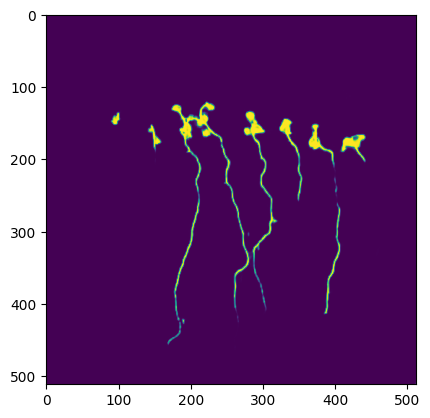

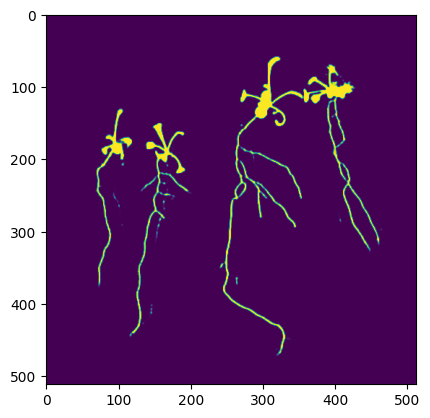

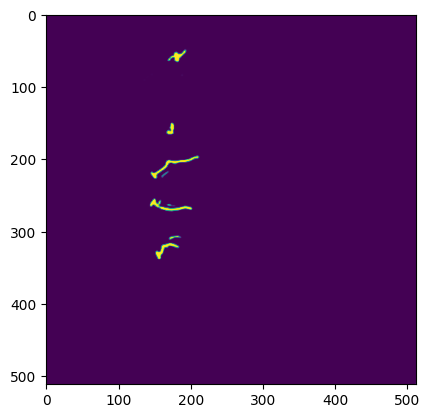

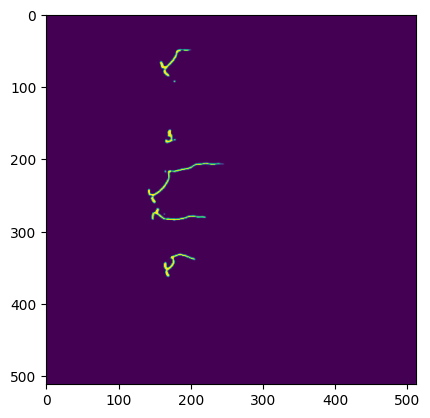

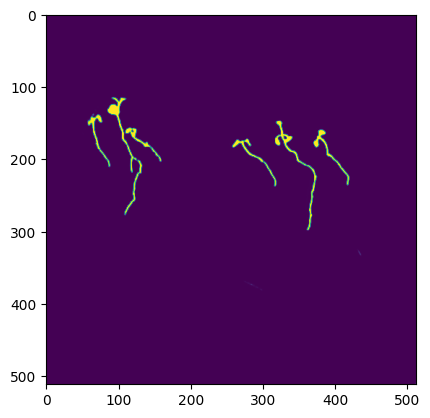

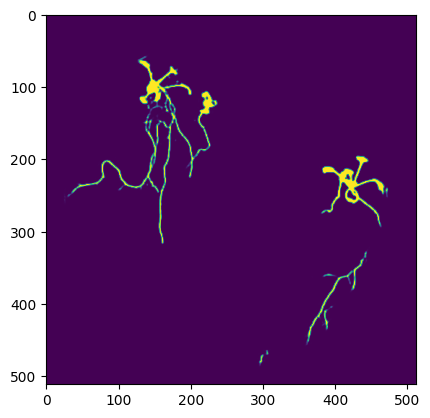

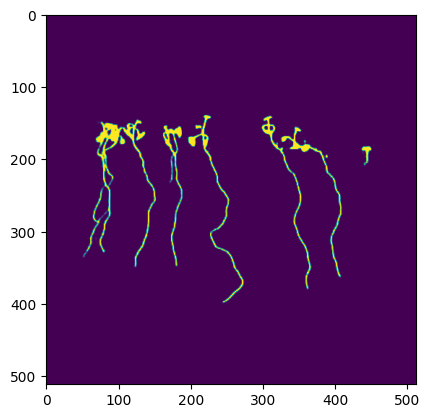

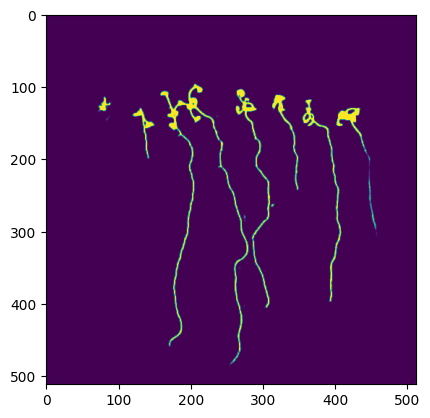

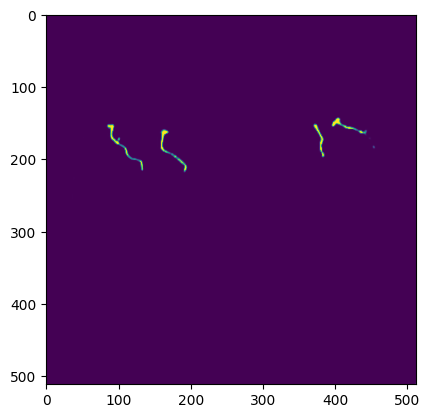

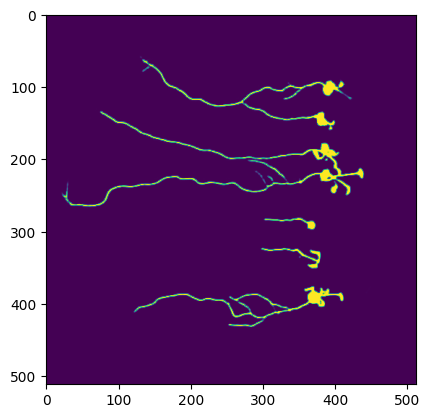

In [37]:
for i in outputs:
    i.reshape(1, height, height)
    plt.imshow(i.cpu().permute(1,2,0).detach().numpy())
    plt.pause(1)